In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import re
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
RESEARCH_TOPIC = 'Multimodal Sentiment Analysis' # Change this to the research topic you are interested in
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY") # Set your OpenAI API key as an environment variable

The dataset is collected from Scopus website using the export function.

The searching criteria is "Title-Abstract-Keywords: Multimodal AND Sentiment AND Analysis".

To prepare your own dataset, the necessary columns are "Title", "Abstract", and "Keywords".

In [4]:
papers = pd.read_csv('papers_data.csv')

print(f'Columns in the dataset: {papers.columns}')
print(f'Number of papers: {len(papers)}')
print(papers.describe())
papers.head()

Columns in the dataset: Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'Molecular Sequence Numbers', 'Chemicals/CAS',
       'Tradenames', 'Manufacturers', 'Funding Details', 'Funding Texts',
       'References', 'Correspondence Address', 'Editors', 'Publisher',
       'Sponsors', 'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')
Number of papers: 1883
              Year    Page count     Cited by  Molecular Sequence Numbers  \
count  1883.000000   1341.000000  1883.000000                   

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,ISBN,CODEN,PubMed ID,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Open Access,Source,EID
0,Zou W.; Sun X.; Lu Q.; Wang X.; Feng J.,"Zou, Wang (58497825600); Sun, Xia (56341695200...",58497825600; 56341695200; 57216037356; 5938823...,A vision and language hierarchical alignment f...,2025,Pattern Recognition,162,NaN,111369,NaN,...,NaN,PTNRA,NaN,English,Pattern Recogn.,Article,Final,NaN,Scopus,2-s2.0-85215442699
1,Wang H.; Du Q.; Xiang Y.,"Wang, Hongbing (59560002000); Du, Qifei (59560...",59560002000; 59560407900; 55836565000,Image–text sentiment analysis based on hierarc...,2025,Engineering Applications of Artificial Intelli...,146,NaN,110262,NaN,...,NaN,EAAIE,NaN,English,Eng Appl Artif Intell,Article,Final,NaN,Scopus,2-s2.0-85217967973
2,Zhang D.,"Zhang, Dingkai (57215547438)",57215547438,Pffm-se: a passenger flow forecasting model fo...,2025,Transportation,NaN,NaN,100122,NaN,...,NaN,NaN,NaN,English,Transportation,Article,Article in press,NaN,Scopus,2-s2.0-85218145146
3,Yang Z.; He Q.; Du N.; He Q.,"Yang, Zhihao (59503587400); He, Qing (57189500...",59503587400; 57189500080; 57222383453; 5897855...,Temporal text-guided feedback-based progressiv...,2025,Alexandria Engineering Journal,116,NaN,NaN,699,...,NaN,NaN,NaN,English,Alexandria Engineering Journal,Article,Final,NaN,Scopus,2-s2.0-85214321812
4,Xiu T.; Gao Y.; Sun Y.; Wu J.; Zhang X.; Zhang...,"Xiu, Taiyu (59559510300); Gao, Yunting (595603...",59559510300; 59560311300; 59560111200; 5955910...,The Analysis of Emotion-Aware Personalized Rec...,2025,Journal of Organizational and End User Computing,37,1,NaN,NaN,...,NaN,NaN,NaN,English,J. Organ. End User Comput.,Article,Final,NaN,Scopus,2-s2.0-85217951146


Data Cleaning and Preprocessing

In [5]:
print("Missing values in each column:")
print(papers.isnull().sum())

# Drop columns where the proportion of missing values is greater than 30%
papers = papers.loc[:, papers.isnull().mean() <= 0.2]

Missing values in each column:
Authors                           206
Author full names                 206
Author(s) ID                      206
Title                               0
Year                                0
Source title                        0
Volume                            708
Issue                            1375
Art. No.                         1463
Page start                        729
Page end                          734
Page count                        542
Cited by                            0
DOI                               345
Link                                0
Affiliations                      208
Authors with affiliations         208
Abstract                            0
Author Keywords                   425
Index Keywords                    414
Molecular Sequence Numbers       1883
Chemicals/CAS                    1882
Tradenames                       1881
Manufacturers                    1881
Funding Details                  1037
Funding Texts      

In [6]:
# Remove DOI column as not necessary for analysis
papers = papers.drop(columns=['DOI'])
papers.dropna(inplace=True)
len(papers)


1650

### Extract country of affiliation

In [7]:
def country_from_affiliation(affiliation):
    # Split the string by comma and extract the last element
    match = re.search(r'(\b\w+\b)\s*;', affiliation)
    if match:
        return match.group(1)
    else:
        # If no semicolon is found, return the last word in the text.
        words = re.findall(r'\b\w+\b', text)
        return words[-1] if words else None


text = "Faculty of Information Engineering and Automation, Kunming University of Science and Technology, Yunnan, Kunming, 650500, China; School of Computer Science and Technology, Yunnan University, Yunnan, Kunming, 650091, China"
print(country_from_affiliation(text))
papers['Country'] = papers['Affiliations'].apply(country_from_affiliation)

China


### Extract institutions from affiliations

In [8]:
def get_main_insitution(affiliation):
    # 1) Take only the first chunk (in case there are multiple separated by semicolons).
    first_chunk = affiliation.split(';')[0].strip()

    keywords = [
        'University', 'College', 'School', 'Institute', 'Academy',
        'Laboratory', 'Lab', 'Center', 'Centre'
    ]

    # 3) Build a regex pattern to capture a phrase that includes at least one of the keywords.
    #    - Starts with a capital word (e.g., "London" or "Faculty")
    #    - Possibly followed by more words or connectors (of / and / in / for / etc.)
    #    - Ends in one of the keywords, and can continue with "of ...", "and ...", etc.
    #
    #    Example match: "London School of Economics and Political Science"
    #    Example match: "Kunming University of Science and Technology"
    #
    #    Explanation:
    #    - [A-Z][a-zA-Z&.\'-]+ : A capital letter followed by letters, &, ., ', or - (a naive "word" with possible punctuation)
    #    - (?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))* : zero or more groups of spaces plus either "of/and/in/for" or another capitalized word
    #    - (?:University|College|School|Institute|Academy|Laboratory|Lab|Center|Centre) : the institution keyword
    #    - (?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))* : optionally more words/connectors after the keyword
    #
    pattern_str = (
        r'([A-Z][a-zA-Z&.\'-]+'
        r'(?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))*\s+'
        r'(?:' + '|'.join(keywords) + r')'
        r'(?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))*)'
    )
    pattern = re.compile(pattern_str)
    
    # 4) Search in the first chunk
    match = pattern.search(first_chunk)
    if match:
        # Return the matched institution phrase
        return match.group(1).strip()
    else:
        # Fallback: if no match, return the entire first chunk
        return first_chunk
    
text = "School of Computer Science, Monash University, Melbourne, VIC 3800, Australia"
print(get_main_insitution(text))
papers['Institution'] = papers['Affiliations'].apply(get_main_insitution)

Monash University


### Extract first author

In [9]:
def extract_first_author(text):
    # Split the string by comma and extract the first element
    return text.split(';')[0].strip()

papers['First Author'] = papers['Authors'].apply(extract_first_author)

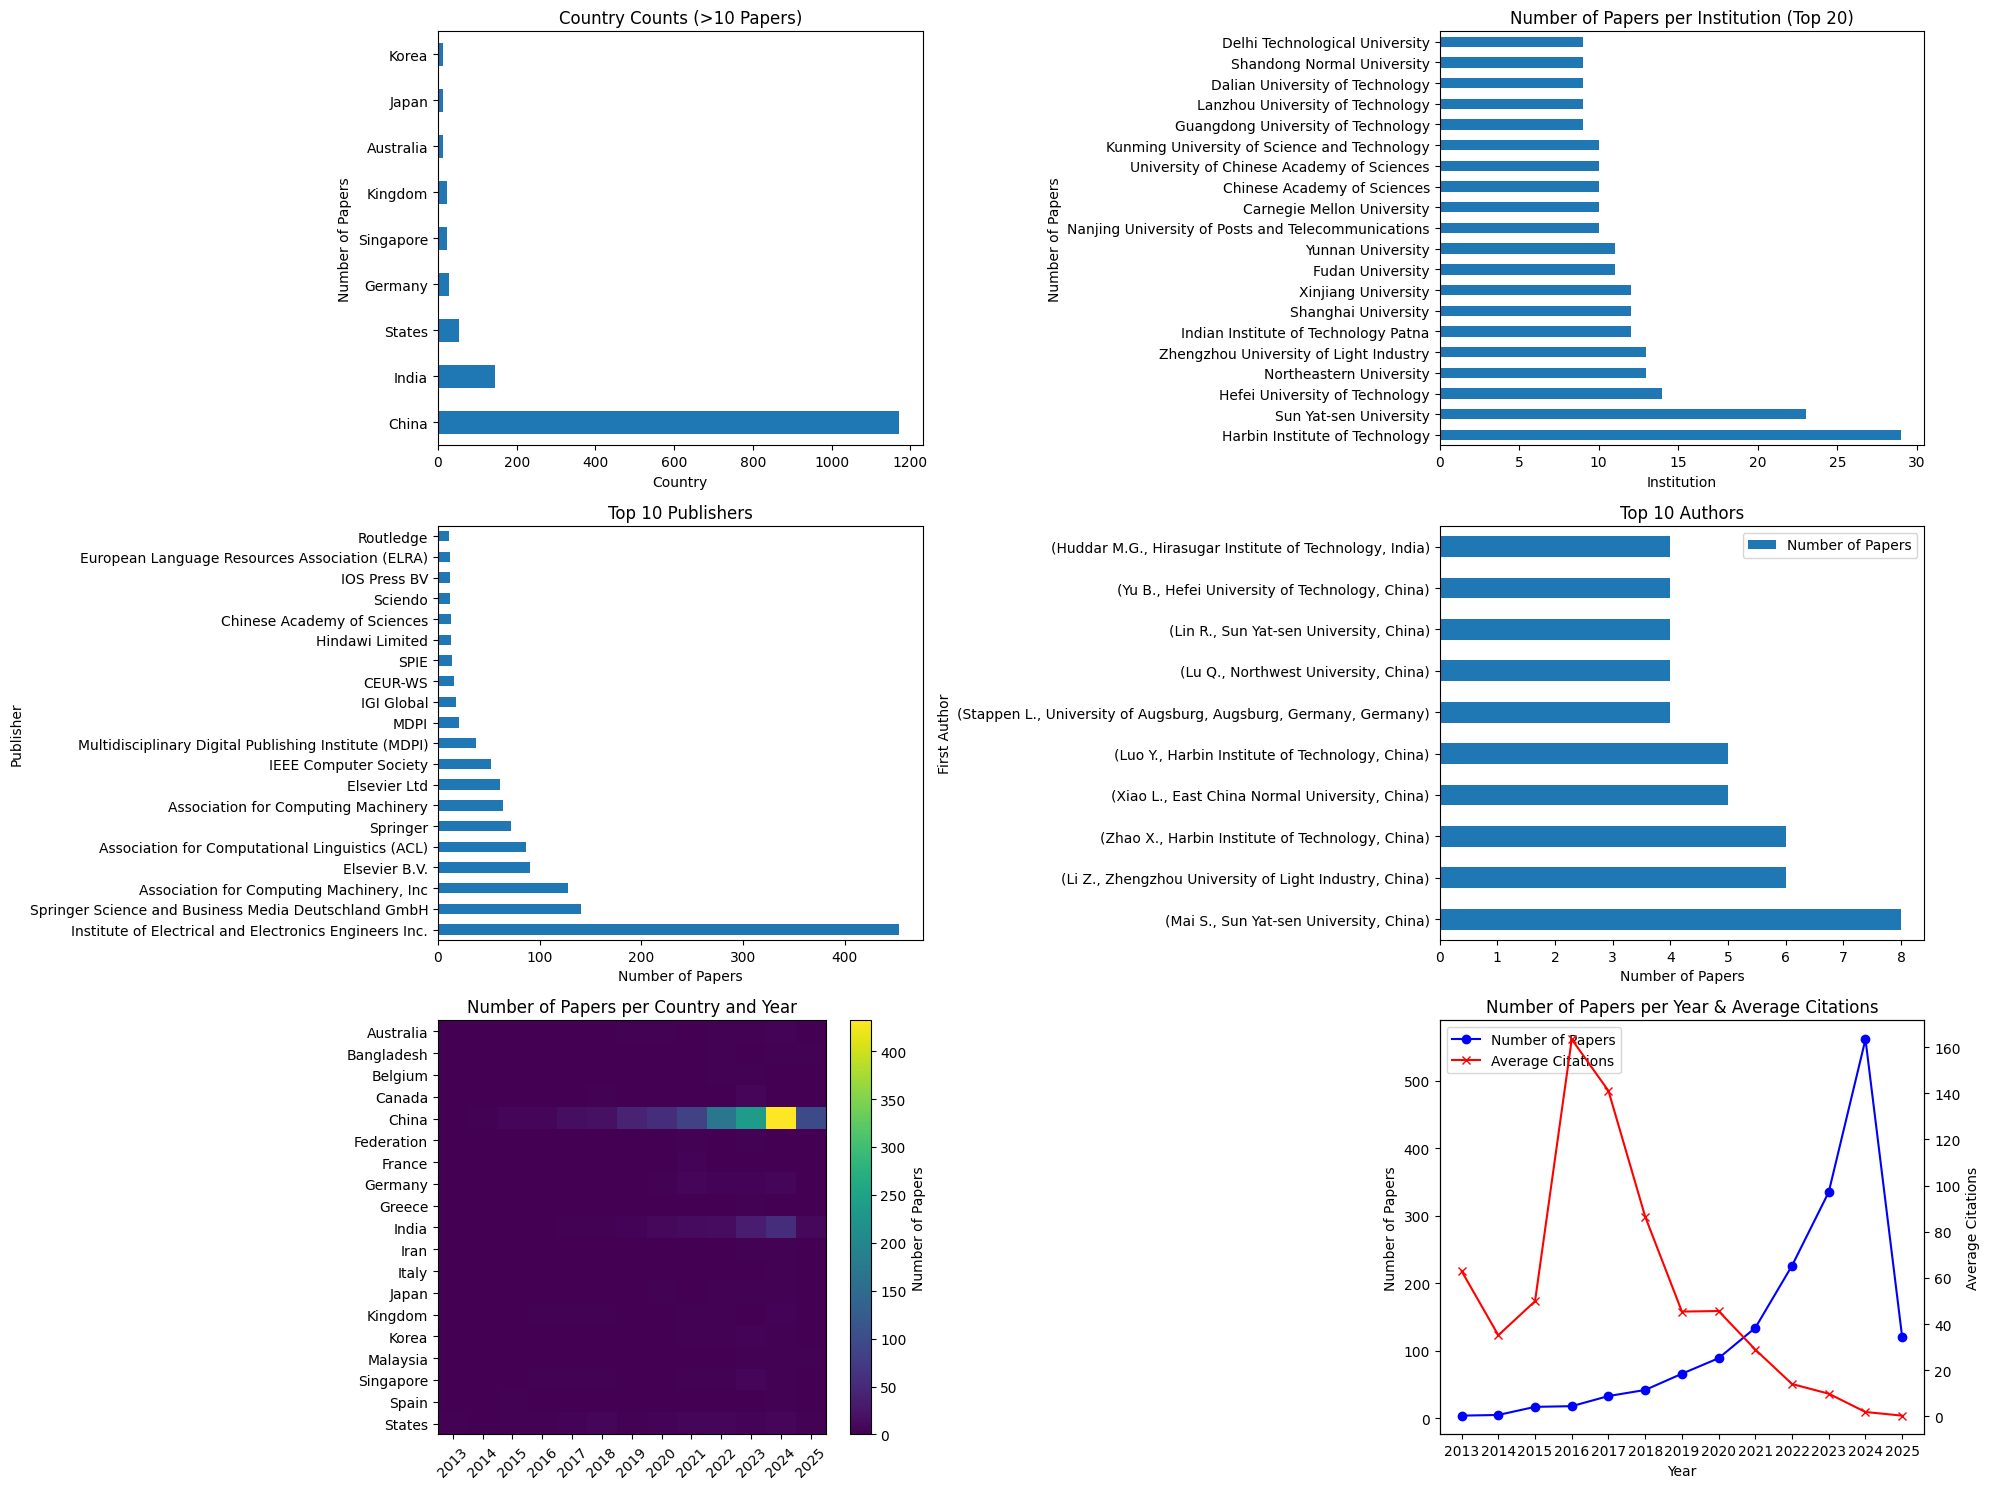

In [10]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs = axs.flatten()  # Flatten to simplify indexing

# 1. Plot: Country counts (>10 papers)
country_counts = papers['Country'].value_counts()
country_counts = country_counts[country_counts > 10]
country_counts.plot(kind='barh', ax=axs[0])
axs[0].set_title('Country Counts (>10 Papers)')
axs[0].set_xlabel('Country')
axs[0].set_ylabel('Number of Papers')

# 2. Plot: Institution counts (Top 20)
institution_counts = papers['Institution'].value_counts().sort_values(ascending=False)[:20]
institution_counts.plot(kind='barh', ax=axs[1])
axs[1].set_title('Number of Papers per Institution (Top 20)')
axs[1].set_xlabel('Institution')
axs[1].set_ylabel('Number of Papers')

# 3. Plot: Top 10 Publishers
publisher = papers['Publisher'].value_counts().sort_values(ascending=False)[:20]
publisher.plot(kind='barh', ax=axs[2])
axs[2].set_title('Top 10 Publishers')
axs[2].set_xlabel('Number of Papers')
axs[2].set_ylabel('Publisher')

# 4. Plot: Top 10 Authors (by first author and institution)
author_count = papers.groupby(['First Author', 'Institution', 'Country'])['First Author']\
                     .count().sort_values(ascending=False)[:10]
author_count.plot(kind='barh', ax=axs[3])
axs[3].set_title('Top 10 Authors')
axs[3].set_xlabel('Number of Papers')
axs[3].set_ylabel('First Author')
axs[3].legend(['Number of Papers'])

# 5. Plot: Heatmap of papers per country and year
country_year_counts = papers.groupby(['Country', 'Year']).size().unstack().fillna(0)
country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 5]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
im = axs[4].imshow(country_year_counts, aspect='auto')
axs[4].set_title('Number of Papers per Country and Year')
axs[4].set_yticks(range(len(country_year_counts)))
axs[4].set_yticklabels(country_year_counts.index)
axs[4].set_xticks(range(len(country_year_counts.columns)))
axs[4].set_xticklabels(country_year_counts.columns, rotation=45)
fig.colorbar(im, ax=axs[4], label='Number of Papers')

# 6. Plot: Number of papers per year and average citations
count = papers.groupby('Year').count()
avg_cite = papers.groupby('Year')['Cited by'].mean()
# Plot number of papers on the primary y-axis
count.plot(y='Title', ax=axs[5], label='Number of Papers', color='blue', marker='o')
axs[5].set_title('Number of Papers per Year & Average Citations')
axs[5].set_xticks(count.index)
axs[5].set_xlabel('Year')
axs[5].set_ylabel('Number of Papers')
# Create a secondary y-axis for average citations
ax2 = axs[5].twinx()
avg_cite.plot(ax=ax2, label='Average Citations', color='red', marker='x')
ax2.set_ylabel('Average Citations')
# Combine legends from both axes
lines1, labels1 = axs[5].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[5].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [11]:
aggregated_data = {}

# 1. Country counts (only include countries with more than 10 papers)
aggregated_data['country_paper_counts'] = country_counts.to_dict()

# 2. Institution counts (top 20)
aggregated_data['institution_paper_counts'] = institution_counts.to_dict()

# 3. Publisher counts (top 20)
aggregated_data['publisher_paper_counts'] = publisher.to_dict()

# 4. Top 10 Authors (grouped by First Author, Institution, Country)
aggregated_data['top_authors'] = author_count.to_dict()

# 5. Country-Year counts (for the heatmap)
aggregated_data['country_year_paper_counts'] = country_year_counts.to_dict()

# 6. Papers per year (from the 'Title' count) and average citations per year
aggregated_data['papers_per_year'] = count['Title'].to_dict()
aggregated_data['average_citations_by_year'] = avg_cite.to_dict()

In [12]:
import json
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

prompt_template = """
Below is a JSON summary of publication data related to {RESEARCH_TOPIC}:

{aggregated_data}

Please provide a detailed analysis of this data, focusing on:
1) Which countries have the most publications?
2) Which institutions are most active?
3) Which publishers appear most often?
4) How have citations changed over the years?
5) Any notable trends you see in this dataset.
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["aggregated_data", "RESEARCH_TOPIC"]
)

llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # choose a model you prefer
    temperature=0.5,
)

chain = prompt | llm

aggregated_data_json = json.dumps(str(aggregated_data), indent=2)
response = chain.invoke({
    "aggregated_data": aggregated_data_json, 
    "RESEARCH_TOPIC": RESEARCH_TOPIC
})


print("Analysis from OpenAI:\n")
print(response.content)

Analysis from OpenAI:

1) The countries with the most publications in Multimodal Sentiment Analysis are China with 1172 papers, India with 146 papers, and the United States with 53 papers.

2) The most active institutions in this field are Harbin Institute of Technology with 29 papers, Sun Yat-sen University with 23 papers, and Hefei University of Technology with 14 papers.

3) The publishers that appear most often in this dataset are Institute of Electrical and Electronics Engineers Inc. with 454 papers, followed by Springer Science and Business Media Deutschland GmbH with 141 papers, and the Association for Computing Machinery, Inc with 128 papers.

4) Citations have varied over the years, with the average number of citations per paper being highest in 2016 at 163.39 and lowest in 2025 at 0.37. There seems to be a general downward trend in average citations over the years, with a peak in 2016.

5) Some notable trends in this dataset include the significant increase in publications fr

### Now we will create embeddings for the papers' abstracts, title and keyword using an embedding model on hugging face
#### I have chosen to use https://huggingface.co/Qdrant/all_miniLM_L6_v2_with_attentions here. You can choose any other model from hugging face as per your requirement. I have chosen this to keep the model size small.


In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [13]:
# Combine the title and abstract into a single text for each paper
import torch
papers['text_for_embedding'] = "passage: " + papers['Title'] + ". " + papers['Abstract']
texts = papers['text_for_embedding'].tolist()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
embeddings = model.encode(texts, normalize_embeddings=True)

We will need to reduce the dimensionality of embeddings to be able to cluster them. We will use UMAP for this purpose.

In [14]:
import umap
umap_model = umap.UMAP()
reduced_embeddings = umap_model.fit_transform(embeddings)

### Simple Hyperparameter Tuning

In [23]:
from sklearn.metrics import silhouette_score
import hdbscan
import numpy as np


def tune_hdbscan_params(embeddings, min_cluster_sizes, min_samples_list=None):
    """
    Tune HDBSCAN parameters and evaluate with silhouette score.
    
    Parameters:
    -----------
    embeddings : array-like
        The input embeddings to cluster
    min_cluster_sizes : list
        List of min_cluster_size values to try
    min_samples_list : list, optional
        List of min_samples values to try. If None, uses min_cluster_sizes values.
    
    Returns:
    --------
    pandas.DataFrame
        Results containing parameters and scores
    """
    if min_samples_list is None:
        min_samples_list = min_cluster_sizes
    
    results = []
    
    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_list:
            # Create and fit the HDBSCAN model
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                cluster_selection_epsilon=0.0,  # Default value
                metric='euclidean'              # Default metric
            )
            
            clusters = clusterer.fit_predict(embeddings)
            
            # Only calculate silhouette score if we have more than one cluster
            # and not all points are noise (-1)
            unique_labels = np.unique(clusters)
            n_clusters = len(unique_labels[unique_labels != -1])
            
            if n_clusters > 1 and len(clusters[clusters != -1]) > 1:
                # Calculate silhouette score only on points assigned to clusters (not noise)
                valid_indices = clusters != -1
                if sum(valid_indices) > 1:
                    sil_score = silhouette_score(
                        embeddings[valid_indices], 
                        clusters[valid_indices]
                    )
                else:
                    sil_score = np.nan
            else:
                sil_score = np.nan
            
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'n_clusters_found': n_clusters,
                'noise_points': sum(clusters == -1),
                'silhouette_score': sil_score
            })
    
    return pd.DataFrame(results)

# Example usage
min_cluster_sizes = [5, 10, 15, 20, 25]
min_samples_list = [1, 3, 5, 7, 10]
params_df = tune_hdbscan_params(reduced_embeddings, min_cluster_sizes, min_samples_list)
params_df

,min_cluster_size,min_samples,n_clusters_found,noise_points,silhouette_score
0,5,1,134,300,0.464188
1,5,3,89,473,0.529700
2,5,5,62,587,0.572204
3,5,7,45,646,0.540722
4,5,10,28,614,0.453333
5,10,1,61,304,0.463462
6,10,3,54,508,0.529002
7,10,5,27,359,0.350693
8,10,7,23,508,0.415167
9,10,10,21,495,0.415110


### We try to balance between number of clusters and silhouette score

In [30]:
# First, decide on your preferred number of clusters
preferred_max_clusters = 30  # Adjust this value based on your needs

# Filter results to only include rows with a reasonable number of clusters
filtered_params = params_df[params_df['n_clusters_found'] <= preferred_max_clusters]

# Remove any rows with NaN silhouette scores
filtered_params = filtered_params.dropna(subset=['silhouette_score'])

# Sort by silhouette score in descending order
best_params = filtered_params.sort_values('silhouette_score', ascending=False).reset_index(drop=True)

# Display the top results
print("Best parameter combinations (with cluster constraint):")
print(best_params.head())

# Get the single best combination
if not best_params.empty:
    best_combination = best_params.iloc[0]
    print("\nOptimal parameters:")
    print(f"min_cluster_size: {best_combination['min_cluster_size']}")
    print(f"min_samples: {best_combination['min_samples']}")
    print(f"Resulting clusters: {best_combination['n_clusters_found']}")
    print(f"Silhouette score: {best_combination['silhouette_score']:.4f}")
    print(f"Noise points: {best_combination['noise_points']}")
else:
    print("No valid parameter combinations found with your constraints.")

Best parameter combinations (with cluster constraint):
   min_cluster_size  min_samples  n_clusters_found  noise_points  \
0                15           10                17           512   
1                 5           10                28           614   
2                10            7                23           508   
3                10           10                21           495   
4                25            7                 2             9   

   silhouette_score  
0          0.455622  
1          0.453333  
2          0.415167  
3          0.415110  
4          0.374228  

Optimal parameters:
min_cluster_size: 15.0
min_samples: 10.0
Resulting clusters: 17.0
Silhouette score: 0.4556
Noise points: 512.0


In [33]:
# Apply AgglomerativeClustering for clustering
import hdbscan


clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(best_combination['min_cluster_size']),
    min_samples=int(best_combination['min_samples'])
)

clusters = clusterer.fit_predict(reduced_embeddings)

papers['cluster'] = clusters


cluster_to_topic = {-1: "Noise/Outliers"}
for cluster_id in set(clusters):
    if cluster_id != -1:
        cluster_to_topic[cluster_id] = f"Topic {cluster_id + 1}"

# Add topic names to the DataFrame
papers['topic'] = papers['cluster'].map(cluster_to_topic)
papers.groupby('cluster').size()

cluster
-1     512
 0      25
 1      24
 2      90
 3      21
 4      23
 5      23
 6      17
 7     171
 8      23
 9      28
 10    269
 11     20
 12     28
 13     39
 14     52
 15    220
 16     65
dtype: int64

In [44]:
papers['title_with_abstract'] = papers['Title'] + '\n\n' + papers['Abstract']

In [50]:
import pandas as pd
import numpy as np
# from openai import OpenAI
import os
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

# Set up OpenAI client (you'll need an API key)
# client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))  # Set your API key as an environment variable


def extract_cluster_keywords(df, text_column, cluster_column, n_keywords=10):
    """
    Extract distinguishing keywords for each cluster using term frequency analysis.
    This can supplement or replace LLM naming if you want a more data-driven approach.
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Get unique clusters, ignoring noise (-1)
    clusters = sorted([c for c in df[cluster_column].unique() if c != -1])
    cluster_keywords = {}
    
    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', min_df=5, max_df=0.8)
    tfidf_matrix = vectorizer.fit_transform(df[df[cluster_column] != -1][text_column])
    feature_names = vectorizer.get_feature_names_out()
    
    for cluster_id in clusters:
        # Get indices of documents in this cluster
        cluster_indices = df[df[cluster_column] == cluster_id].index.tolist()
        cluster_indices = [i for i in cluster_indices if i < tfidf_matrix.shape[0]]  # Ensure indices are valid
        
        if not cluster_indices:
            cluster_keywords[cluster_id] = ["No documents"]
            continue
            
        # Get the average TF-IDF scores for this cluster
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0).A1
        
        # Get the top keywords for this cluster
        top_indices = np.argsort(cluster_tfidf)[-n_keywords:][::-1]
        top_keywords = [feature_names[i] for i in top_indices]
        
        cluster_keywords[cluster_id] = top_keywords
    
    return cluster_keywords

keywords = extract_cluster_keywords(papers, 'title_with_abstract', 'cluster', n_keywords=15)
papers['cluster_keywords'] = papers['cluster'].map(keywords)
keywords

{0: ['data',
  'information',
  'emotion',
  'image',
  'language',
  'learning',
  'level',
  'expression',
  'feature',
  'temporal',
  'user',
  'facial',
  'abusive',
  'based',
  'contrastive'],
 1: ['graph',
  'modalities',
  'representations',
  'information',
  'data',
  'learning',
  'based',
  'modal',
  'modality',
  'image',
  'aspect',
  'feature',
  'fusion',
  'language',
  'network'],
 2: ['modality',
  'data',
  'fusion',
  'modalities',
  'information',
  'features',
  'model',
  'text',
  'missing',
  'method',
  'visual',
  'based',
  'modal',
  'social',
  'video'],
 3: ['multitask',
  'topic',
  'videos',
  'emotion',
  'relations',
  'data',
  'media',
  'image',
  'humor',
  'text',
  'news',
  'cross',
  'social',
  'aspect',
  'visual'],
 4: ['text',
  'image',
  'aspect',
  'social',
  'information',
  'graph',
  'based',
  'data',
  'level',
  'features',
  'feature',
  'multi',
  'audio',
  'modal',
  'fusion'],
 5: ['task',
  'text',
  'media',
  'social',

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import json

def name_clusters_with_llm(df, text_column, cluster_column, sample_size=5, model="gpt-4"):
    llm = ChatOpenAI(model_name=model, temperature=0.3)
   # Create prompt template for batch processing
    prompt_template = ChatPromptTemplate.from_template("""
    I have {num_clusters} different clusters of documents from a larger collection.
    Please create a unique, concise, descriptive name (2-5 words) for each cluster based on the keywords or examples provided.
    
    Make sure each cluster name is UNIQUE and clearly distinguishable from other cluster names.
    Each name should capture the essence of the cluster content.
    
    Here are the clusters:
    
    {cluster_data_json}
    
    Return ONLY a valid JSON object with cluster IDs as keys and cluster names as values. Format:
    {{
      "0": "First Cluster Name",
      "1": "Second Cluster Name",
      ...
    }}
    """)

    chain = prompt_template | llm
    # Get unique clusters, ignoring noise (-1)

    clusters = sorted([c for c in df[cluster_column].unique() if c != -1])
    
    # Prepare cluster data for all clusters
    cluster_data = []
    
    for cluster_id in clusters:
        # Get keywords for this cluster
        if 'cluster_keywords' in df.columns:
            # If keywords are already in the dataframe
            keywords = df[df[cluster_column] == cluster_id]['cluster_keywords'].iloc[0]
            if isinstance(keywords, list):
                keywords_text = ', '.join(keywords)
            else:
                keywords_text = keywords
        
        cluster_data.append({
            "cluster_id": int(cluster_id),
            "keywords_or_examples": keywords_text
        })
    response = chain.invoke({
        "num_clusters": len(clusters),
        "cluster_data_json": json.dumps(cluster_data, indent=2)
    })
    try:
        cluster_names = json.loads(response.content)
        
        # Convert keys to integers if they were returned as strings
        cluster_names = {int(k): v for k, v in cluster_names.items()}
        
        # Print the results
        for cluster_id, name in cluster_names.items():
            print(f"Cluster {cluster_id}: '{name}'")
            
        return cluster_names
    except json.JSONDecodeError:
        print("Error: Could not parse LLM response as JSON. Raw response:")
        print(response.content)
        
        # Fallback: try to extract cluster names manually
        import re
        pattern = r'"(\d+)":\s*"([^"]+)"'
        matches = re.findall(pattern, response.content)
        
        if matches:
            cluster_names = {int(cluster_id): name for cluster_id, name in matches}
            for cluster_id, name in cluster_names.items():
                print(f"Cluster {cluster_id}: '{name}'")
            return cluster_names
        else:
            return {}

In [59]:
cluster_names = name_clusters_with_llm(papers, 'title_with_abstract', 'cluster', sample_size=3, model="gpt-4")

Cluster 0: 'Emotion Analysis and Learning'
Cluster 1: 'Graph-Based Data Representations'
Cluster 2: 'Multimodal Data Fusion'
Cluster 3: 'Multitask Media Analysis'
Cluster 4: 'Social Aspect Analysis'
Cluster 5: 'Conversational Media Analysis'
Cluster 6: 'Cross-Cultural Network Fusion'
Cluster 7: 'Sarcasm Detection in Social Media'
Cluster 8: 'Emotional Recognition in Modalities'
Cluster 9: 'User Sentiment Analysis'
Cluster 10: 'Emotion-Based Learning Fusion'
Cluster 11: 'Health Technology Learning Graph'
Cluster 12: 'Sarcasm Detection with Global Attention'
Cluster 13: 'Social Emotion Recognition'
Cluster 14: 'Media Classification and Fusion'
Cluster 15: 'Feature-Based Learning Fusion'
Cluster 16: 'Visual Sarcasm Detection'


In [61]:
papers['cluster_name'] = papers['cluster'].map(cluster_names)

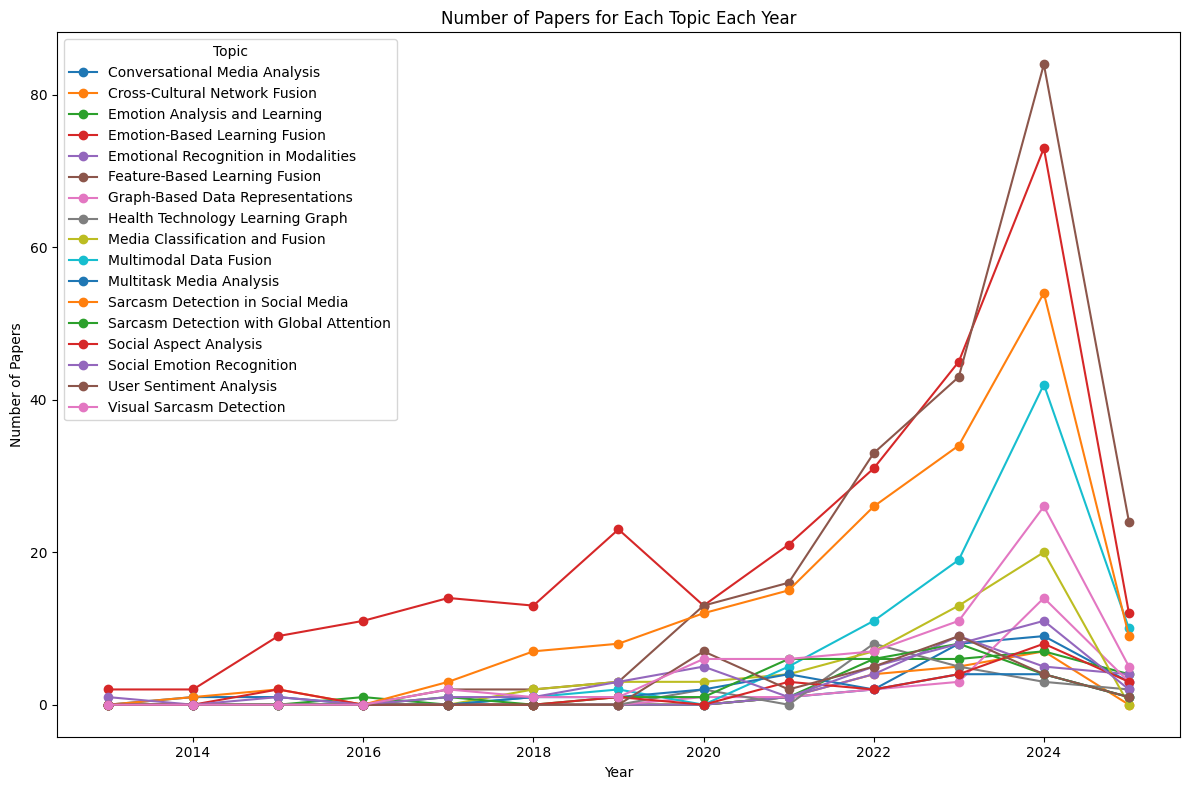

In [67]:

# Ensure 'Year' is treated as numeric or categorical as appropriate
papers['Year'] = pd.to_numeric(papers['Year'], errors='coerce')

# Group by Year and topic, then count the number of papers
counts = papers.groupby(['Year', 'cluster_name']).size().unstack(fill_value=0)

# Plot a stacked bar chart
ax = counts.plot(kind='line', marker='o', figsize=(12,8))
ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
ax.set_title('Number of Papers for Each Topic Each Year')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()


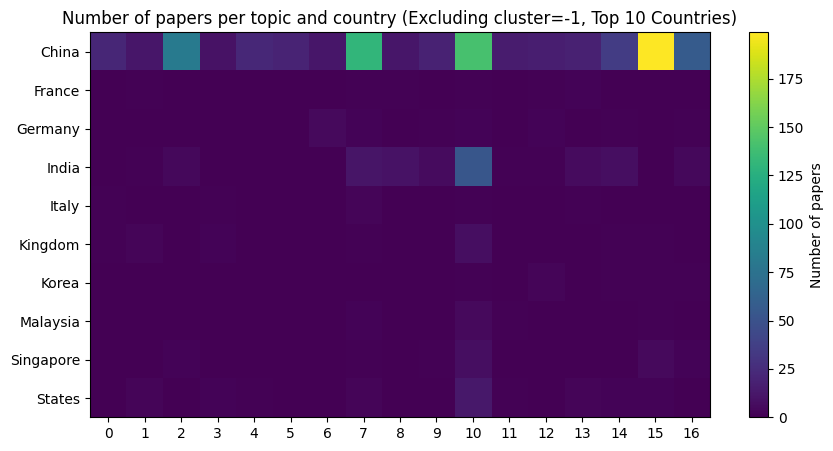

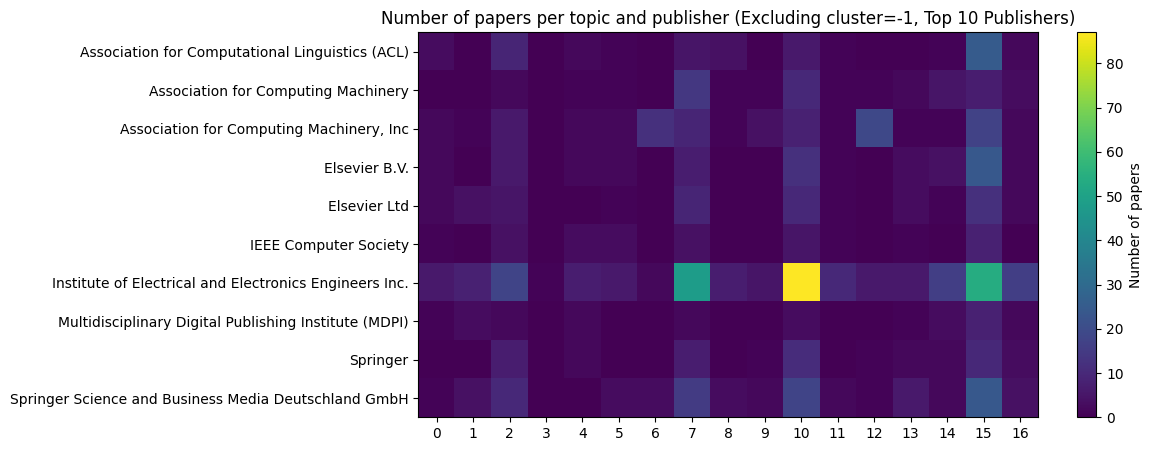

In [ ]:
import matplotlib.pyplot as plt

# 1. Filter out rows where cluster = -1
papers_filtered = papers[papers['cluster'] != -1]

# --------------------------------------------------
#               TOP 10 COUNTRIES
# --------------------------------------------------
top_countries = papers_filtered['Country'].value_counts().head(10).index

papers_countries_top10 = papers_filtered[papers_filtered['Country'].isin(top_countries)]

country_counts = (
    papers_countries_top10
    .groupby(['Country', 'cluster'])
    .size()
    .unstack()
    .fillna(0)
)

country_counts = country_counts.reindex(sorted(country_counts.columns), axis=1)

# 2d. Plot heatmap
plt.figure(figsize=(10, 5))
plt.imshow(country_counts, aspect='auto')
plt.yticks(range(len(country_counts)), country_counts.index)
plt.xticks(range(len(country_counts.columns)), country_counts.columns)
plt.title('Number of papers per topic and country (Excluding cluster=-1, Top 10 Countries)')
plt.colorbar(label='Number of papers')
plt.show()

# --------------------------------------------------
#               TOP 10 PUBLISHERS
# --------------------------------------------------
top_publishers = papers_filtered['Publisher'].value_counts().head(10).index
papers_publishers_top10 = papers_filtered[papers_filtered['Publisher'].isin(top_publishers)]

publisher_counts = (
    papers_publishers_top10
    .groupby(['Publisher', 'cluster'])
    .size()
    .unstack()
    .fillna(0)
)


publisher_counts = publisher_counts.reindex(sorted(publisher_counts.columns), axis=1)

plt.figure(figsize=(10, 5))
plt.imshow(publisher_counts, aspect='auto')
plt.yticks(range(len(publisher_counts)), publisher_counts.index)
plt.xticks(range(len(publisher_counts.columns)), publisher_counts.columns)
plt.title('Number of papers per topic and publisher (Excluding cluster=-1, Top 10 Publishers)')
plt.colorbar(label='Number of papers')
plt.show()
